In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import utils.geo as geo
from xgcm.autogenerate import generate_grid_ds

In [3]:
target='ecco'

In [13]:
# Load dummy file to get lat and lon values
if target=='era5':
    rootdir = '/scratch/gpfs/graemem/'+target+'/'
    localdir = 'reanalysis-era5-single-levels-monthly-means/monthly_averaged_reanalysis/global/annual/1959/'
    filename = 'era5.monthly_averaged_reanalysis.1959.10m_u_component_of_wind.nc'
    axes_dims_dict = {'X':'longitude','Y':'latitude'}
elif target=='merra2':
    rootdir = '/scratch/gpfs/graemem/'+target+'/'
    localdir = 'M2TMNXOCN/'
    filename = 'MERRA2_100.tavgM_2d_ocn_Nx.198001.nc4'
    axes_dims_dict = {'X':'lon','Y':'lat'}
if target=='ecco':
    rootdir = '/projects/SOCCOM/scratch/gpfs/graemem/'+target+'/'
    localdir = 'Version4/Release4/interp_monthly/oceFWflx/1992/'
    filename = 'oceFWflx_1992_01.nc'
    axes_dims_dict = {'X':'lon','Y':'lat'}
ds = xr.open_dataset(rootdir+localdir+filename)
# Reorient coordinate data for ecco
if target=='ecco':
    ds = (
        ds.chunk({'time':60})
          .assign_coords({'i':ds['longitude'],'j':ds['latitude']})
          .rename({'i':'lon','j':'lat'})
    )
# Orient correctly in latitude
ds = ds.sortby(axes_dims_dict['Y'])

In [14]:
ds

<xarray.Dataset>
Dimensions:    (lon: 720, lat: 360, time: 1, nv: 2)
Coordinates:
  * lon        (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat        (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time       (time) datetime64[ns] 1992-01-16T12:00:00
    latitude   (lat) float64 ...
    longitude  (lon) float64 ...
    timestep   (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    oceFWflx   (time, lat, lon) float64 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes: (12/20)
    product_time_coverage_start:  1992-01-01T12:00:00
    author:                       Ou Wang and Ian Fenty
    Insitution:                   JPL
    product_version:              ECCO Version 4 Release 4
    time_units:                   days since 1992-01-01 00:00:00
    Conventions:                  CF-1.6
    ...                           ...
    nz:                           1
    geospatial_vertical_units:    meter
    geospatial_vertical_max:      0
    date_created:                 Thu Aug 22 18:06:00 2019
    time_coverage_start:          1992-01-01T00:00:00
    time_coverage_end:            1992-02-01T00:00:00

In [15]:
ds_new,xgrid = geo.get_xgcm_horizontal(ds,
                                       axes_dims_dict=axes_dims_dict,
                                       position=('center','right'),
                                       periodic='X')

In [16]:
ds_new

<xarray.Dataset>
Dimensions:    (lon: 720, lat: 360, time: 1, nv: 2, lon_right: 720,
                lat_right: 360)
Coordinates:
  * lon        (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat        (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time       (time) datetime64[ns] 1992-01-16T12:00:00
    latitude   (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
    longitude  (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
    timestep   (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
  * lon_right  (lon_right) float64 -179.5 -179.0 -178.5 ... 179.0 179.5 180.0
  * lat_right  (lat_right) float64 -89.5 -89.0 -88.5 -88.0 ... 89.0 89.5 90.0
Dimensions without coordinates: nv
Data variables:
    oceFWflx   (time, lat, lon) float64 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    dxG        (lon_right, lat) float64 242.2 726.5 1.211e+03 ... 726.5 242.2
    dyG        (lon, lat_right) float64 5.55e+04 5.55e+04 ... 5.55e+04 nan
    dxC        (lon, lat) float64 242.2 726.5 1.211e+03 ... 726.5 242.2
    dyC        (lon, lat) float64 nan 5.55e+04 5.55e+04 ... 5.55e+04 5.55e+04
    rC         (lon, lat) float64 nan 4.032e+07 6.72e+07 ... 4.032e+07 1.344e+07
Attributes: (12/20)
    product_time_coverage_start:  1992-01-01T12:00:00
    author:                       Ou Wang and Ian Fenty
    Insitution:                   JPL
    product_version:              ECCO Version 4 Release 4
    time_units:                   days since 1992-01-01 00:00:00
    Conventions:                  CF-1.6
    ...                           ...
    nz:                           1
    geospatial_vertical_units:    meter
    geospatial_vertical_max:      0
    date_created:                 Thu Aug 22 18:06:00 2019
    time_coverage_start:          1992-01-01T00:00:00
    time_coverage_end:            1992-02-01T00:00:00

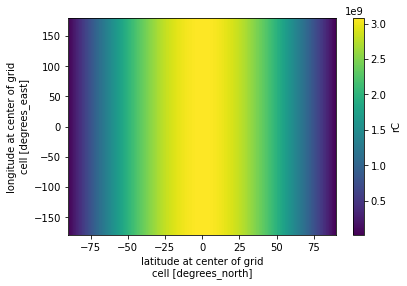

In [17]:
ds_new['rC'].plot()

In [18]:
retain = ['dxG','dyG','dxC','dyC','rC']
ds_new = ds_new[retain]
ds_new.to_netcdf(rootdir+'regular_grid.nc')